# Problem 1

In [1]:
#install.packages("sandwich")
library(lmtest)
library(sandwich)
library(plm)


Warning message:
"package 'lmtest' was built under R version 3.6.3"Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



We simulate the data necessary for the analysis.

In [2]:
set.seed(333)

n <- 500

gama <- 0.5
x <- rnorm(n, 14, 25)
eps <- rnorm(n, 0, abs(x^(2*gama)))
alpha <- 4
beta <- 1

y <- alpha + beta * x + eps

## (a)

In [3]:
# Model estimated by OLS regression
model_ols <- lm(y ~ x)
summary(model_ols)


Call:
lm(formula = y ~ x)

Residuals:
    Min      1Q  Median      3Q     Max 
-171.07   -9.74   -0.36   11.12  122.75 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.57944    1.53998   2.974  0.00308 ** 
x            0.84955    0.05353  15.871  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 29.17 on 498 degrees of freedom
Multiple R-squared:  0.3359,	Adjusted R-squared:  0.3346 
F-statistic: 251.9 on 1 and 498 DF,  p-value: < 2.2e-16


The model estimated by OLS estimated statistically significant alpha to be around 4.6 with relatively large standard error of 1.5. 
Beta coefficient is 0.8 with much smaller standard error 0.05 and p value under 0.1 %.
In the data simulating process, variance of epsilon is dependent on the x. Therefore, we can expect that the errors are not homoskedastic. We will test it using Breusch-Pagan test and by plotting residuals and fitted values from the model.

In [4]:
# Breush-Pagan test
bptest(model_ols)


	studentized Breusch-Pagan test

data:  model_ols
BP = 60.905, df = 1, p-value = 5.989e-15


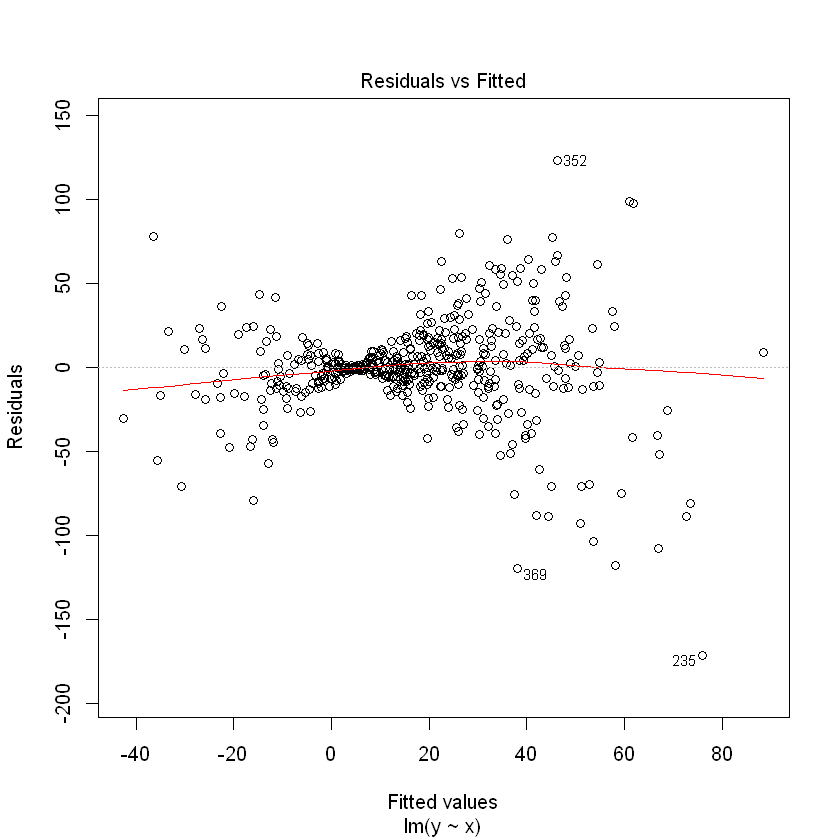

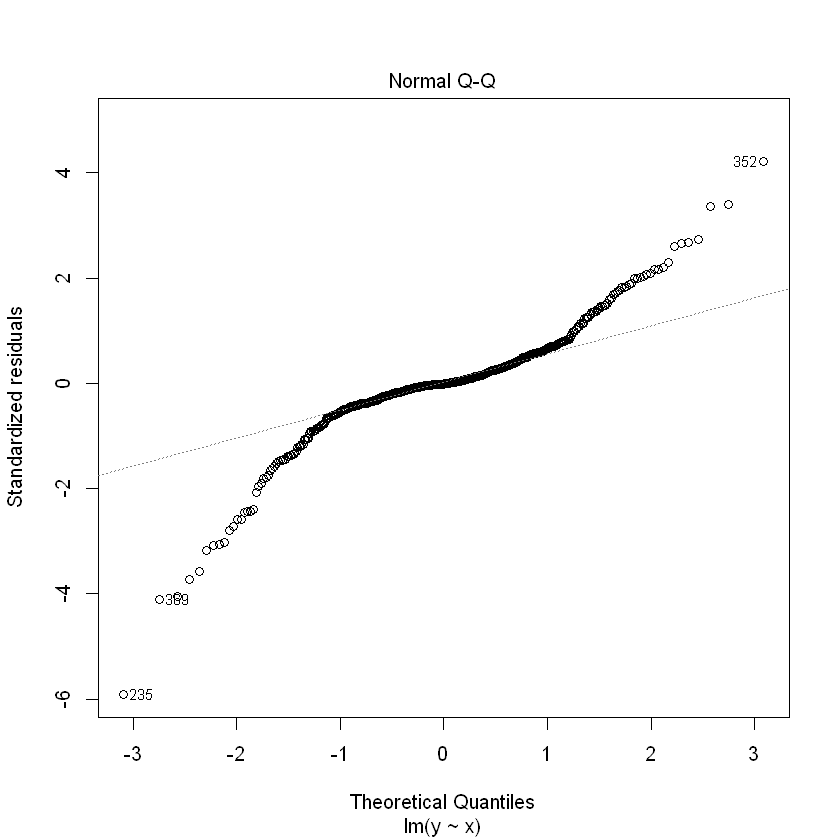

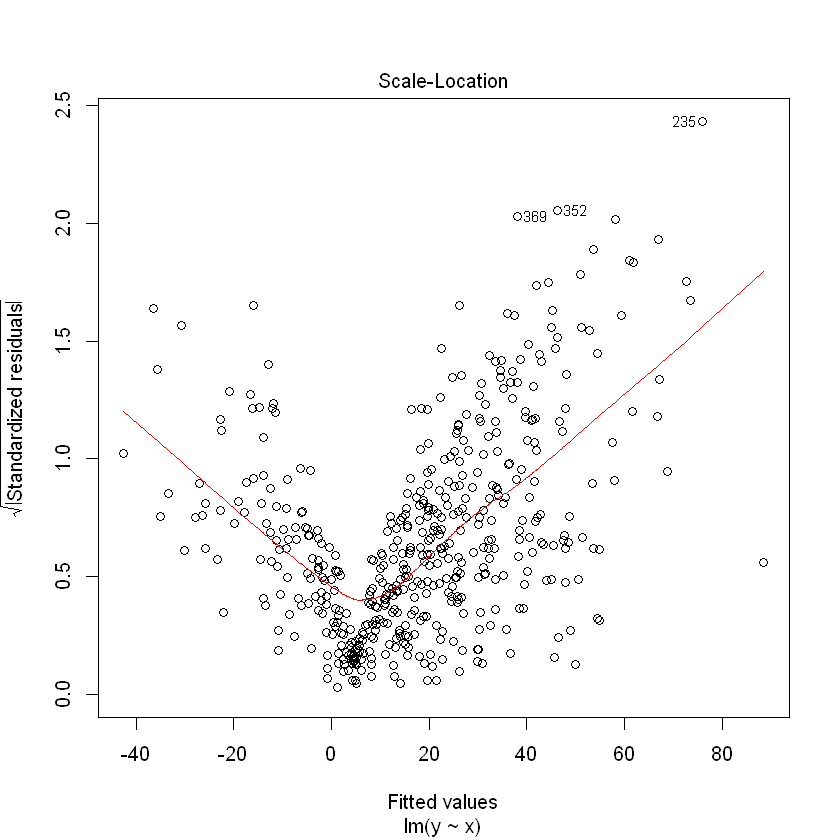

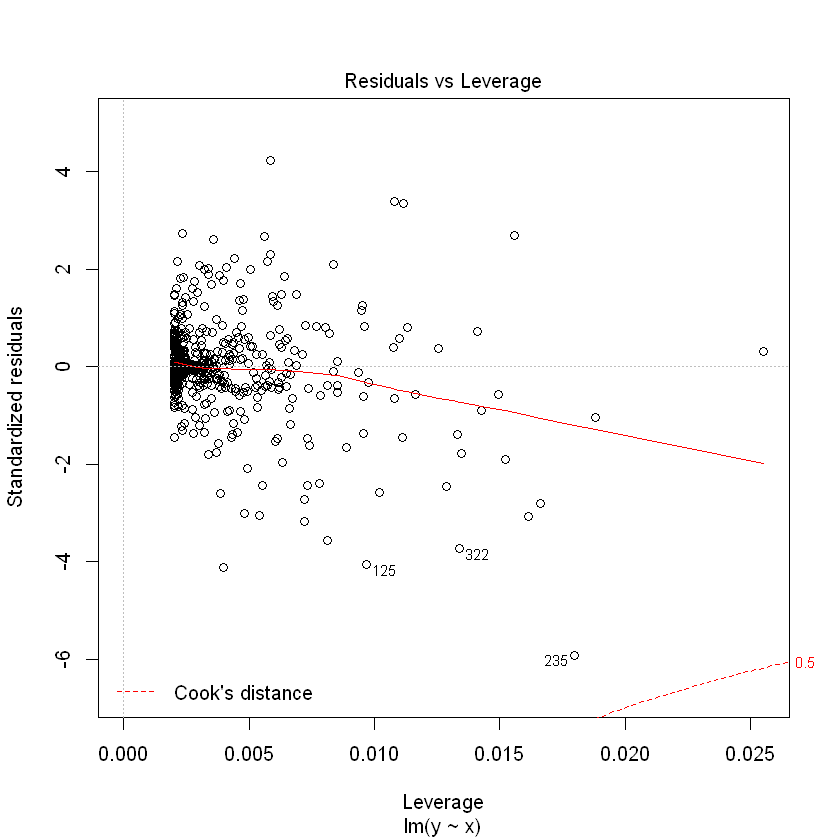

In [5]:
plot(model_ols)

P value resulting from the Breusch-Pagan test is significantly under 0.001 which indicates that the assumption of homoskedasticity is not satisfied.
Plot of the residuals and fitted values shows that the residuals are changing with fitted values which is also an indicator of heteroskedasticity.
We will deal heteroskedasticity by estimating model employing GLS, FGLS and heteroskedasticity robust standard errors.

## (b)

Form of the weighting matrix is $|1/x|$. 
Variance cannot be negative. Therefore, we use absolute values in the matrix. Weighting matrix has a form of diagonal matrix and square roots of the elements are used by the lm function.

In [6]:
# Define weighting matrix for GLS
w <- 1/abs(x)

# Model estimated by GLS
model_gls <- lm(y ~ x, weights = w)
summary(model_gls)


Call:
lm(formula = y ~ x, weights = w)

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-19.7418  -2.3090  -0.2203   2.5723  16.7833 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.00196    0.34958   11.45   <2e-16 ***
x            0.96845    0.04576   21.16   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.847 on 498 degrees of freedom
Multiple R-squared:  0.4735,	Adjusted R-squared:  0.4724 
F-statistic: 447.8 on 1 and 498 DF,  p-value: < 2.2e-16


## (c)

In the previous part, we assumed a specific form of the heteroskedasticity. However, our assumption does not need to be correct. Now, we will work with unkwnown form of the heteroskedasticity. We assume that the variance has a form of a specific function of x

In [7]:
# Define function for weighting matrix
ols_res2 <- resid(model_ols)^2
sigma2 <- lm(log(ols_res2) ~ log(abs(x)))
w2 <- exp(fitted(sigma2))

# Model estimated by FGLS
model_fgls <- lm(y ~ x, weights = 1/w2)
summary(model_fgls)


Call:
lm(formula = y ~ x, weights = 1/w2)

Weighted Residuals:
   Min     1Q Median     3Q    Max 
-7.171 -1.147 -0.128  1.161  6.117 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.98972    0.04988   79.99   <2e-16 ***
x            1.01755    0.04514   22.54   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.945 on 498 degrees of freedom
Multiple R-squared:  0.5051,	Adjusted R-squared:  0.5041 
F-statistic: 508.2 on 1 and 498 DF,  p-value: < 2.2e-16


In [8]:
summary(ols_res2)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    0.001    12.003   107.329   847.669   517.162 29263.612 

## (d)

In [9]:
# White's standard errors
coeftest(model_ols, vcov = vcovHC(model_ols, type = "HC0"))


t test of coefficients:

            Estimate Std. Error t value  Pr(>|t|)    
(Intercept) 4.579440   1.207963  3.7910 0.0001684 ***
x           0.849549   0.086935  9.7722 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [10]:
# Create table with standard errors from all methods
comparison <- matrix(ncol = 2, nrow = 4)
colnames(comparison) <- c("alpha", "beta")
rownames(comparison) <- c("White's", "OLS", "GLS", "FGLS")

comparison[1,] <- c(1.207963,0.086935)
comparison[2, ] <- summary(model_ols)$coefficients[,2]
comparison[3, ] <- summary(model_gls)$coefficients[, 2]
comparison[4, ] <- summary(model_fgls)$coefficients[, 2]

print(comparison)

             alpha       beta
White's 1.20796300 0.08693500
OLS     1.53998165 0.05352713
GLS     0.34958377 0.04576283
FGLS    0.04987765 0.04513690


Standard errors obtained using White's standard errors are slightly lower for alpha and higher for beta compared to OLS method.
GLS and FGLS provided significantly lower standard errors for both coefficients. For beta, GLS and FGLS provided similar results, while for alpha the standard error estimated by FGLS is almost ten times smaller compared to GLS.

# Problem 2

In [1]:
library(plm)
library(lmtest)
library(tseries)

Loading required package: Formula


Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


In [2]:
data("Wages", package = "plm")
Wag <- pdata.frame(Wages, index=595)

In [3]:
pdim(Wag)
data.frame(NA_Sum = colSums(is.na(Wag)))
head(Wag)


Balanced Panel: n = 595, T = 7, N = 4165

,NA_Sum
exp,0
wks,0
bluecol,0
ind,0
south,0
smsa,0
married,0
sex,0
union,0
ed,0


,exp,wks,bluecol,ind,south,smsa,married,sex,union,ed,black,lwage,id,time
1-1,3,32,no,0,yes,no,yes,male,no,9,no,5.56068,1,1
1-2,4,43,no,0,yes,no,yes,male,no,9,no,5.72031,1,2
1-3,5,40,no,0,yes,no,yes,male,no,9,no,5.99645,1,3
1-4,6,39,no,0,yes,no,yes,male,no,9,no,5.99645,1,4
1-5,7,42,no,1,yes,no,yes,male,no,9,no,6.06146,1,5
1-6,8,35,no,1,yes,no,yes,male,no,9,no,6.17379,1,6


We begin with data exploration. The panel data set is balanced with 595 individuals over 7 years and no NAs - no need for handling the data structure.

#### (a) Pooled OLS

In [4]:
pols <- plm(lwage ~ ed + exp + I(exp^2) + sex + south + smsa + black, data=Wag,
            model = "pooling")
summary(pols)

Pooling Model

Call:
plm(formula = lwage ~ ed + exp + I(exp^2) + sex + south + smsa + 
    black, data = Wag, model = "pooling")

Balanced Panel: n = 595, T = 7, N = 4165

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-2.2121430 -0.2328048 -0.0021319  0.2340662  2.0421768 

Coefficients:
               Estimate  Std. Error  t-value  Pr(>|t|)    
(Intercept)  5.3293e+00  3.6005e-02 148.0148 < 2.2e-16 ***
ed           6.5286e-02  2.0955e-03  31.1553 < 2.2e-16 ***
exp          4.2775e-02  2.1752e-03  19.6642 < 2.2e-16 ***
I(exp^2)    -7.2209e-04  4.7965e-05 -15.0544 < 2.2e-16 ***
sexfemale   -4.2420e-01  1.7978e-02 -23.5953 < 2.2e-16 ***
southyes    -6.9485e-02  1.2436e-02  -5.5874 2.452e-08 ***
smsayes      1.7062e-01  1.2094e-02  14.1077 < 2.2e-16 ***
blackyes    -1.8012e-01  2.2220e-02  -8.1063 6.802e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Total Sum of Squares:    886.9
Residual Sum of Squares: 524.21
R-Squared:      0.40894
Adj.

In [5]:
coeftest(pols, vcov = vcovHC(pols, type = "HC0", cluster = 'group'))


t test of coefficients:

               Estimate  Std. Error  t value  Pr(>|t|)    
(Intercept)  5.3293e+00  7.9804e-02  66.7806 < 2.2e-16 ***
ed           6.5286e-02  4.7120e-03  13.8555 < 2.2e-16 ***
exp          4.2775e-02  4.3314e-03   9.8756 < 2.2e-16 ***
I(exp^2)    -7.2209e-04  9.8662e-05  -7.3188 2.987e-13 ***
sexfemale   -4.2420e-01  3.1539e-02 -13.4498 < 2.2e-16 ***
southyes    -6.9485e-02  2.6680e-02  -2.6044  0.009238 ** 
smsayes      1.7062e-01  2.5507e-02   6.6893 2.540e-11 ***
blackyes    -1.8012e-01  4.5735e-02  -3.9383 8.340e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


We continue with model estimation based on provided equation describing how wage of an individual is affected by his or her working experience, years of education, urban areas residence, sex, south residence, and race. We incorporated all of the variables in a given form (log, square).

The first estimated model is poold OLS, which is usef for cases when the individual effect $z_i$ is observed. In other words, the individuals are observed over time but posses no individual-specific characteristics. Assuming everyone has also non-observable determinants of his or her wage, e.g. ability, we do not believe this model turns out to be accurate. Finally, we expect the heterogeneity in our residuals so that we also decided to use robus standard errors as a prevention - formal test is going to be performed later.

Our results suggest that there is a statistically significant effect of education on individual's wage - 1 year of education is predicted to increase individuals wage by 6.59% in average. Althouth, the adjusted $R^2$ reaching only 40.8% suggest we could also further specify our model.   

#### (b) Fixed effects

In [6]:
fem_w <- plm(lwage ~ ed + exp + I(exp^2) + sex + south + smsa + black, 
                data=Wag, model = "within")
summary(fem_w)

Oneway (individual) effect Within Model

Call:
plm(formula = lwage ~ ed + exp + I(exp^2) + sex + south + smsa + 
    black, data = Wag, model = "within")

Balanced Panel: n = 595, T = 7, N = 4165

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-1.8120080 -0.0504228  0.0039655  0.0607171  1.9430322 

Coefficients:
            Estimate  Std. Error t-value  Pr(>|t|)    
exp       1.1380e-01  2.4655e-03 46.1575 < 2.2e-16 ***
I(exp^2) -4.2839e-04  5.4499e-05 -7.8605 5.026e-15 ***
southyes  5.3877e-03  3.4186e-02  0.1576   0.87478    
smsayes  -4.3365e-02  1.9399e-02 -2.2354   0.02546 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Total Sum of Squares:    240.65
Residual Sum of Squares: 82.562
R-Squared:      0.65692
Adj. R-Squared: 0.59939
F-statistic: 1707.05 on 4 and 3566 DF, p-value: < 2.22e-16

In [7]:
individuals <- unique(Wag$id)
ed_changes <- numeric(length(individuals))

for (i in seq_along(individuals)) {
  subset_data <- subset(Wag, id == individuals[i])
  ed_changes[i] <- length(unique(subset_data$ed)) > 1
}

result_table <- data.frame(individual_id = individuals, ed_changes = ed_changes)
print(result_table[, ed_changes != 0])

data frame with 0 columns and 595 rows


The second model used for an estimation is Fixed effect model. This method assumes the individual-specific effect to be present and unobserved, however, correlated with regressors. This method attempts to averege the individual effect out by taking an average of variables over time.

The issue of thie metod is, hoever, that cannot be used for estimating a time-invarient variable. Since we did not obtain a coefficient for 'ed' at all, we believe it remains constant for every individual over time and is thus averaged out by this algorithm. The reason for that can be that individuals in our data set are already working adults whose level of education is logically the same over this couple of years. 

#### (c) Random effects

In [8]:
rem <- plm(lwage ~ ed + exp + I(exp^2) + sex + south + smsa + black, 
            data=Wag, model = "random")
summary(rem)

Oneway (individual) effect Random Effect Model 
   (Swamy-Arora's transformation)

Call:
plm(formula = lwage ~ ed + exp + I(exp^2) + sex + south + smsa + 
    black, data = Wag, model = "random")

Balanced Panel: n = 595, T = 7, N = 4165

Effects:
                  var std.dev share
idiosyncratic 0.02315 0.15216 0.239
individual    0.07386 0.27176 0.761
theta: 0.793

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-2.0620658 -0.1147357  0.0083296  0.1202484  2.0863357 

Coefficients:
               Estimate  Std. Error  z-value  Pr(>|z|)    
(Intercept)  4.16329227  0.08165324  50.9875 < 2.2e-16 ***
ed           0.10348971  0.00550150  18.8112 < 2.2e-16 ***
exp          0.08377489  0.00284146  29.4830 < 2.2e-16 ***
I(exp^2)    -0.00081571  0.00006273 -13.0033 < 2.2e-16 ***
sexfemale   -0.27605996  0.04819024  -5.7285 1.013e-08 ***
southyes    -0.01686609  0.02677860  -0.6298 0.5288027    
smsayes     -0.01421970  0.02006775  -0.7086 0.4785822    
blackyes    -0.20309

Thirdly, we used Random effects method of estimation. This is the best option for cases when the individual-specific heterogeneous feature is unobserved and uncorrelated with regressors. The variables are time-demeaned only partially and what, thefore, alows us to estimate also time-invariant variable capturing education.  

Our results show that there is a statistically significant effect of education on individual's wage - every additional level of edducation seems to increase wage by 10.35% in average. Although the adjusted $R^2$ being only 39.1% does not indicate a strong-specified model.

#### (e) Testing

To compare our models, we perform several test.

In [9]:
pFtest(fem_w, pols)


	F test for individual effects

data:  lwage ~ ed + exp + I(exp^2) + sex + south + smsa + black
F = 32.277, df1 = 591, df2 = 3566, p-value < 2.2e-16
alternative hypothesis: significant effects


The F test aims to uncover presence of individual-specific fixed effects. Since the null hypothesis was rejected due to the low p-value, we can assume that there are significant effects in our data as expected. It can be characteristics of individuals such as ability or networking skills. It means that we did not treat this effects in the Pooled OLS model, therefore, obtained inconsistent and biased results due to endogeneity. 

In [10]:
plmtest(pols, type = c("bp"), effect = "individual")
plmtest(pols, type = c("bp"), effect = "time")
plmtest(pols, type = c("bp"), effect = "twoway")


	Lagrange Multiplier Test - (Breusch-Pagan) for balanced panels

data:  lwage ~ ed + exp + I(exp^2) + sex + south + smsa + black
chisq = 3789.7, df = 1, p-value < 2.2e-16
alternative hypothesis: significant effects



	Lagrange Multiplier Test - time effects (Breusch-Pagan) for balanced
	panels

data:  lwage ~ ed + exp + I(exp^2) + sex + south + smsa + black
chisq = 60406, df = 1, p-value < 2.2e-16
alternative hypothesis: significant effects



	Lagrange Multiplier Test - two-ways effects (Breusch-Pagan) for
	balanced panels

data:  lwage ~ ed + exp + I(exp^2) + sex + south + smsa + black
chisq = 64196, df = 2, p-value < 2.2e-16
alternative hypothesis: significant effects


Secondly, we used also the Breuschen-Pagan LM test to detect the individual-specific effects in the residuals that allows us to look for individual, time or both effects. We rejected all 3 null hypotheses due to low p-values. This suggests that there is an individual-specific heteroskedasticity and the Pooled OLS estimates biased results. This result only confirmes the previous test.   

In [11]:
phtest(fem_w, rem)


	Hausman Test

data:  lwage ~ ed + exp + I(exp^2) + sex + south + smsa + black
chisq = 5347.6, df = 4, p-value < 2.2e-16
alternative hypothesis: one model is inconsistent


Even though we cannot use the Fixed effects model due to estimating effect of a time-invarient variable, we still run the Hausman test to see the difference between Fixed and Random effect methods. This test allows us to compare these models since it detects the exogeneity of effects under the null hypothesis. Rejecting the null with the low p-value tells us that one of these models is inconsistent. Therefore, we can use only Fixed effects model to obtain consistent result while the Random effect being inconsistent.   

To conclude, even though we found a significant effect of education on individual's wage, this results turned out to be inconsistent since both Pooled OLS and Random effects are not eligible to use. The best method of estimation would be the Fixed effects, however, we cannot use it since the education is constant over time for all our samples. Therefore, we have no idea how ability affects wage from this data and would need to restructure our model. One example is to try also different method of estimation, such as first differencing, or LSDV.

#### (f) OLS assumptions

Finally, we test also for other standard OLS assumptions for panel data to see what else should be treated for consistent or unbiased model estimation. We'll performe the tests using Random effects model, others analogically.

In [12]:
adf.test(Wag$lwage, k = 4)

Warning message in adf.test(Wag$lwage, k = 4):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  Wag$lwage
Dickey-Fuller = -20.853, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


There seems to be no unit roots in our dependent variable that would distort our results - we can assume stationarity.

In [13]:
pbgtest(rem)


	Breusch-Godfrey/Wooldridge test for serial correlation in panel models

data:  lwage ~ ed + exp + I(exp^2) + sex + south + smsa + black
chisq = 791.46, df = 7, p-value < 2.2e-16
alternative hypothesis: serial correlation in idiosyncratic errors


Using the Breusch-Godfrey test, we found strong autocorrelation among the errors that needs to be treated for consistent estimates.

In [14]:
bptest(rem)


	studentized Breusch-Pagan test

data:  rem
BP = 53.179, df = 7, p-value = 3.418e-09


Since we found also the heteroskedasticity in our data due to rejecting the null hypothesis of Breusch-Pagan test, we correctly used the robust standard errors above to keep our standard errors consistent.

In conclusion, our results are not consistent at all but we now where the issue is :)

# Problem 3

In [ ]:
head(Wag)
subWag=subset(Wag,time==2) #subsample with t=2
head(subWag)

In [ ]:
#ols
ols<-lm(lwage~ed+smsa+black,data=subWag)
summary(ols)
#testing for heteroskedasticity
bptest(ols)
gqtest( ols, order.by= subWag[ ,'black'])

Based on the Breusch Pagan test, we can reject homoskedasticity at a 5% level. Also, the GQ test rejects that variances between the black and non-black subsamples are equal and constant. Thus, both tests indicate heteroskedasticity.

In [ ]:
#estimation subsamples of black and non-black 
black_ols <- lm(lwage~ed+smsa, data = subWag, subset = (black == "yes")) 
nonblack_ols <- lm(lwage~ed+smsa, data = subWag, subset = (black == "no"))
sigblack <- summary(black_ols)$sigma
signonblack <- summary(nonblack_ols)$sigma
print((signonblack - sigblack)/sigblack)

The relative difference between the estimated variances for each group is 14%

In [ ]:
#Creating FGLS
subWag$weight <- rep(0, nrow(subWag))

for (i in 1:nrow(subWag))
{
  if (subWag$black[i] == 0){subWag$weight[i] <- 1 / signonblack^2}
  else{subWag$weight[i] <- 1 / sigblack^2}
}

fgls <- lm(lwage~ed+smsa+black, weights = weight, data = subWag) 

In [ ]:
summary(fgls) #FGLS estimator
summary(ols)

Both models provide similar results for coefficients, their significance and standard errors, indicating that heteroskedasticity is not significant within black and non-black groups.